#**Deep Learning Homework 4: *Recurrent Neural Networks & Transformer***
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Dr. Luca Pasa
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.


#Requirements

In [ ]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━

#Imports

In [ ]:
import torch
from torch import nn
from torch.nn import Embedding, RNN, LSTM, GRU, Linear, Transformer
import torch.nn.functional as F
from torchinfo import summary
from torchtext.datasets import IMDB
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision.transforms import Lambda
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
rng = np.random.default_rng(seed=4242)

#Data Loading and Preprocessing

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). As usual, for speed and efficiency, we will use only a subset of the dataset. Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. We load the data from the PyTorch database and then split the data into train, validation and test set.

In [ ]:
train, test = IMDB(root="dataset", split=('train', 'test'))
Tr, Ts = list(train), list(test)
rng.shuffle(Tr)
rng.shuffle(Ts)
len_train, len_val, len_test = 25000, 12500, 12500 # Whole data
train_data, val_data, test_data = Tr[:len_train], Ts[:len_val], Ts[len_val:len_val+len_test]

In [ ]:
len(train_data), len(val_data), len(test_data)

(25000, 12500, 12500)

In [ ]:
idx = 10
label_samp, text_samp = train_data[idx]
print(f"text: {text_samp}")
print(f"label: {label_samp}")

text: Assuming this won't end up a straight-to-video release, I would have to say void this title at all costs. Unless you're bored of good, well-executed movies, that is. I saw this last night at AFI Dallas, and I left with 20 minutes remaining, simply because I didn't care anymore (about the plot, not about insulting the director...that is awkward). When you can spot a goof only 5 minutes into the movie (a shot out, shattered window before any shots are fired...and then the window breaks with the first shot), things are going to bad. Let's just say this is only an indicator of things to come...unfortunately.<br /><br />I'll spare you all the details, but this is sub-par in every manner, even the half-assed acting by Michael Madsen is disappointing when you're expecting half-assed acting from him. And the rape scene...Christ! "Shut up and take it" should never be used in a rape scene. EVER.<br /><br />3/10
label: 1


Let's check the dataset statistics.

In [ ]:
datasets = {'train':train_data, 'val':val_data, 'test':test_data}
for key in datasets:
  label_dist = {}
  dataset = datasets[key]
  for lb, txt in dataset:
    if lb not in label_dist:
      label_dist.setdefault(lb, 1)
    else:
      label_dist[lb] += 1
  print(f"{key}:")
  print(label_dist)


train:
{1: 12500, 2: 12500}
val:
{2: 6245, 1: 6255}
test:
{2: 6255, 1: 6245}


In [ ]:
tokenizer = get_tokenizer('basic_english')

def create_tokens(dataset):
  for sample in dataset:
    yield tokenizer(sample[1])

vocab = build_vocab_from_iterator(create_tokens(train_data), specials=["<oov>", "<sos>"], max_tokens=10000)
vocab.set_default_index(vocab["<oov>"])
print(f"Our vocabulary is made of {len(vocab)} tokens-index pairs.")

Our vocabulary is made of 10000 tokens-index pairs.


In [ ]:
print(train_data[0][0]) # the first component is the label
print(train_data[0][1]) # the second one is the actual text
print(tokenizer(train_data[0][1])) # it returns a list of the tokenized words

1
MY BROTHER TOM <br /><br />Aspect ratio: 1.85:1<br /><br />Sound format: Dolby Digital<br /><br />Following an episode of sexual abuse at the hands of a trusted neighbor, young Jessica (Jenna Harrison) forms a relationship with a strange boy (Ben Whishaw) she meets in the woods. Unfortunately, Whishaw has secrets of his own, no less troubling and far more dangerous...<br /><br />Dour drama, sparked by brave performances by Harrison and Whishaw, in which two kindred spirits immerse themselves in a mutual love of nature after being traumatized by their experiences in the 'real world'. Unfortunately, their friendship unravels as harsh reality begins to intrude, leading to an inevitable tragedy. Directed by Dom Rotheroe and photographed in digital video format, the movie looks ragged in places (too many awkward close-ups and sloppy hand-held camera moves) and takes a while to find its feet, but the dramatic pay-off is quietly rewarding.
['my', 'brother', 'tom', 'aspect', 'ratio', '1', '.

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [ ]:
print(vocab.get_itos())  # top 10000 freq words (including special chars)

['<oov>', '<sos>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'", 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', ')', '(', 'you', 't', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', '!', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'so', 'like', 'there', 'her', 'or', 'just', 'about', 'if', 'has', 'out', 'what', '?', 'some', 'good', 'can', 'more', 'when', 'she', 'very', 'even', 'my', 'no', 'up', 'would', 'time', 'which', 'only', 'story', 'really', 'their', 'see', 'had', 'we', 'were', 'me', 'than', 'well', 'much', '-', 'get', 'been', 'people', 'will', 'also', 'other', 'bad', 'into', 'do', 'because', 'great', 'first', 'how', 'him', 'don', 'most', 'its', 'made', 'then', 'them', 'way', 'could', 'make', 'too', 'any', 'after', 'movies', 'think', 'characters', 'character', 'watch', 'films', 'two', 'many', 'seen', 'being', 'never', 'little', 'plot', 'acting', 'where', 'best', 'love', 'did', 'life', 'show', 'know', 'does', 'ever', 'here',

In [ ]:
word_index = {k:v for (k, v) in enumerate(vocab.get_itos())}

In [ ]:
# word_ids = (text_pipeline(text_samp)), is a list. The id refers to the vocabulary
def decode_review(word_ids):
    return " ".join([word_index.get(word_id, "<err>") for word_id in word_ids])

print(text_samp)
print("\n")
print(decode_review(text_pipeline(text_samp)))

Assuming this won't end up a straight-to-video release, I would have to say void this title at all costs. Unless you're bored of good, well-executed movies, that is. I saw this last night at AFI Dallas, and I left with 20 minutes remaining, simply because I didn't care anymore (about the plot, not about insulting the director...that is awkward). When you can spot a goof only 5 minutes into the movie (a shot out, shattered window before any shots are fired...and then the window breaks with the first shot), things are going to bad. Let's just say this is only an indicator of things to come...unfortunately.<br /><br />I'll spare you all the details, but this is sub-par in every manner, even the half-assed acting by Michael Madsen is disappointing when you're expecting half-assed acting from him. And the rape scene...Christ! "Shut up and take it" should never be used in a rape scene. EVER.<br /><br />3/10


assuming this won ' t end up a straight-to-video release , i would have to say void

In [ ]:
print(text_pipeline(text_samp))

[5633, 14, 379, 9, 27, 138, 66, 6, 8830, 778, 4, 13, 67, 33, 8, 141, 7109, 14, 429, 38, 37, 2146, 3, 881, 26, 9, 183, 1081, 7, 57, 4, 0, 109, 4, 15, 10, 3, 13, 220, 14, 237, 320, 38, 0, 7762, 4, 5, 13, 318, 20, 979, 235, 3662, 4, 331, 92, 13, 163, 9, 27, 462, 1597, 25, 50, 2, 121, 4, 29, 50, 3472, 2, 173, 3, 3, 3, 15, 10, 2074, 24, 3, 60, 26, 58, 1547, 6, 0, 70, 573, 235, 90, 2, 21, 25, 6, 330, 53, 4, 0, 2019, 165, 107, 654, 31, 3368, 3, 3, 3, 5, 101, 2, 2019, 1970, 20, 2, 94, 330, 24, 4, 189, 31, 177, 8, 89, 3, 283, 9, 16, 49, 141, 14, 10, 70, 41, 0, 7, 189, 8, 218, 3, 3, 3, 471, 3, 13, 9, 240, 4045, 26, 37, 2, 1337, 4, 22, 14, 10, 5861, 12, 181, 1330, 4, 63, 2, 0, 122, 40, 480, 6787, 10, 1295, 60, 26, 9, 183, 989, 0, 122, 43, 96, 3, 5, 2, 1559, 142, 3, 3, 3, 2937, 36, 2928, 66, 5, 199, 11, 149, 119, 34, 349, 12, 6, 1559, 142, 3, 131, 3, 2743]


To keep the length of the all the input sequences same, we define the padding function. All the sentence less than the lenght of 500 will be padded with zeros and greater than 500 will be truncated. Notice that we will pad and truncate sequences right-wise, so that processing the sequences, the final hidden states of the recurrent networks will correspond to the final words of each sequence in the batch.



In [ ]:
def sent_padding(sent_vec, maxlen):
  sent_vec = torch.tensor(sent_vec)
  maxlen -= len(sent_vec)
  return F.pad(sent_vec, (maxlen, 0))


print(sent_padding([1,2,3], maxlen=6)) # notice that the padding is applied right-wise. Therefore the zeros are added to the left
print(sent_padding([1,2,3,4,5,6,7,8,9], maxlen=6))

tensor([0, 0, 0, 1, 2, 3])
tensor([4, 5, 6, 7, 8, 9])


In [ ]:
seq_len = 500
sent_padding(text_pipeline(text_samp), maxlen=seq_len)

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# "__name_of_the_magic_method_" are invoked without any call, when an instance of a class is created
# In this case
class CustomDataset(Dataset):

  def __init__(self, dataset, seq_len=seq_len):
    super().__init__()
    self.dataset = dataset
    self.seq_len = seq_len

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    label, text = self.dataset[idx]
    label = label_pipeline(label)
    txt_rep = sent_padding(text_pipeline(text), maxlen=self.seq_len)
    label, txt_rep = torch.tensor(label, dtype=torch.float32), torch.tensor(txt_rep, dtype=torch.long)
    return label.to(device), txt_rep.to(device)

In [ ]:
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_data)

In [ ]:
batch_size=256
dataloader_training = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

#Model Definition

Let's define the model:
- The first layer is an Embedding layer, with input_dim=vocab_dim and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- The output layer

### Model Comparison

In order to perform a fair comparison of the models RNN, LSTM and GRU make sure they use more or less the same number of parameters.

In the next cell, we define our simple RNN used for binary classification. The class has two main methods, the constructor (`init()`) and the `forward()` method.

In the constructor, the input parameters are used to define the layers and hyperparameters of the RNN. The layers that are defined include an embedding layer (`self.embedding`), a recurrent layer (`self.rnn`), and a linear layer (`self.linear`). The constructor also sets up various parameters such as the embedding input size, the embedding output size, the hidden size, the number of layers, the batch size, the RNN type, and whether or not the RNN is bidirectional.

The `forward()` method takes a batch of input data (`x`) and applies the layers defined in the constructor in a specific sequence. First, the input is passed through the embedding layer to create embeddings of the input tokens. These embeddings are then permuted to be of the correct shape for the RNN layer, which expects inputs of the form (`seq_len, batch_size, H_in`). The RNN layer is then applied to these embeddings, producing both the RNN output (`rnn_out`) and the last hidden state (`self.last_hidden`). Finally, the output of the RNN is passed through a linear layer and flattened to produce the final output of the network, which is a sigmoid activation function applied to a tensor of shape (`batch_size`). This output is then returned.

In [ ]:
class My_RNN(nn.Module):
  def __init__(self, vocab_length, emb_dim, hidden_size, num_layers,
               batch_size, RNN_type, bidirectional, device=device):
    super().__init__()
    ################################################################################
    # EMBEDDING
    self.emb_in_dim = vocab_length  # 10000
    self.emb_out_dim = emb_dim  # 10
    ################################################################################
    # NETWORK ARCHITECTURE
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    #################################################################################
    self.batch_size = batch_size
    self.RNN_type = RNN_type
    self.target_size = 1  # binary classification
    self.device = device
    self.D = 2 if self.bidirectional else 1  # enable/disable bidirectional


    valid_types = {'Simple RNN':RNN, 'LSTM':LSTM, 'GRU':GRU}
    assert self.RNN_type in valid_types.keys(), f'You must choose one of {valid_types.keys()} types'
    ################################################################################

    self.embedding = Embedding(self.emb_in_dim, self.emb_out_dim)

    chosen_rnn = valid_types[self.RNN_type]
    #################################################################################

    self.rnn = chosen_rnn(input_size = self.emb_out_dim,
                          hidden_size = self.hidden_size,
                          num_layers = self.num_layers,
                          bidirectional = self.bidirectional)
    ################################################################################

    self.linear = Linear(self.D*self.hidden_size, self.target_size)

  def forward(self, x):
    #x: (batch_size, 500)
    # The function "Embedding()" is applied to the instance "x"
    self.embeds = self.embedding(x)
    #embeds: (batch_size, 500, 10)


    #But rnn receives inputs of: (500, batch_size, 10) (seq_len, batch_size, H_in)

    # HERE WE HAVE TO CHANGE THE ORDER OF THE ELEMENTS
    self.embeds = self.embeds.permute(1, 0, 2)
    #embeds: (500, batch_size, 10) -> Now the shape is correct

    rnn_out, self.last_hidden = self.rnn(self.embeds)
    #rnn_out: (500, 256, 2*5:10) -> (seq_len, batch_size, D*hidden_size)
    #h_n: (1, 256, hidden_size) -> (D*num_layers, batch_size, hidden_size)
    output = self.linear(rnn_out[-1, :, :])
    #output: (256, 1) -> (batch_size, target_size)
    output = output.flatten()
    #output: (256) -> (batch_size)
    return F.sigmoid(output)

### Simple RNN

We define a RNN model and evaluate its performance. Your task is to choose the right loss function and motivate your choice.



ANSWER: The model is aiming to capture if the review is positive or negative, hence the classification underconsideration a binary one. This leads to choose the Binary Cross Entropy.

In [ ]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'Simple RNN' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()#[TO COMPLETE]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─RNN: 1-2                               1,408
├─Linear: 1-3                            33
Total params: 101,441
Trainable params: 101,441
Non-trainable params: 0

In [ ]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 51.50%, Loss: 0.69147795 ---------------- Val_Acc: 52.65%, Val_Loss: 0.69003683
epoch: 2 -> Accuracy: 54.16%, Loss: 0.68723685 ---------------- Val_Acc: 53.42%, Val_Loss: 0.68710530
epoch: 3 -> Accuracy: 55.92%, Loss: 0.68073738 ---------------- Val_Acc: 54.47%, Val_Loss: 0.68293107
epoch: 4 -> Accuracy: 57.70%, Loss: 0.67351252 ---------------- Val_Acc: 54.11%, Val_Loss: 0.68463320
epoch: 5 -> Accuracy: 59.61%, Loss: 0.66364449 ---------------- Val_Acc: 62.85%, Val_Loss: 0.64913028
epoch: 6 -> Accuracy: 61.63%, Loss: 0.65211332 ---------------- Val_Acc: 60.66%, Val_Loss: 0.65966600
epoch: 7 -> Accuracy: 64.96%, Loss: 0.62630439 ---------------- Val_Acc: 64.94%, Val_Loss: 0.63114375
epoch: 8 -> Accuracy: 62.31%, Loss: 0.64429700 ---------------- Val_Acc: 59.47%, Val_Loss: 0.66068459
epoch: 9 -> Accuracy: 65.87%, Loss: 0.61489540 ---------------- Val_Acc: 67.06%, Val_Loss: 0.60913128
epoch: 10 -> Accuracy: 70.88%, Loss: 0.56659496 ---------------- Val_Acc: 69.46%, 

It's time to plot the results...

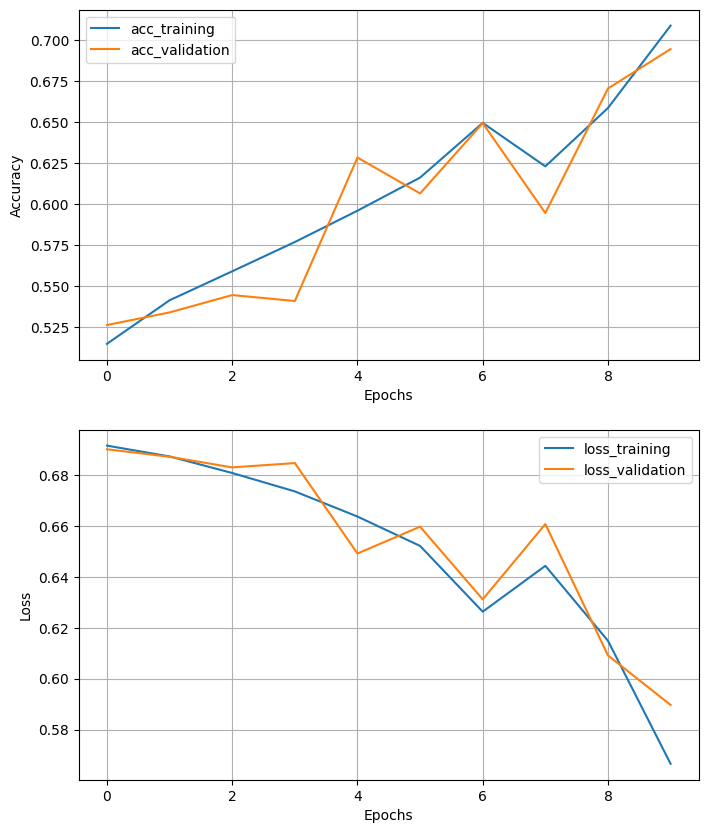

In [ ]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(EPOCHS), acc_tr, label='acc_training')
    plt.plot(range(EPOCHS), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(EPOCHS), loss_tr, label='loss_training')
    plt.plot(range(EPOCHS), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

...and see the performances on the test set:

In [ ]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")


In [ ]:
test(model)

Test Loss: 0.58736879 ---------- Test Accuracy: 69.4960%


We should achieve ~60% accuracy on test set. Lets see if we can improve further!

### LSTM

In this Exercise, you have to implement [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) model, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM layer. Print the model summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

 In order to ensure reproducibility across all the future models implementations let's create a function to call before each model is initialized and trained.
 Pytorch Reproducibility:
 https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
import random
def seed_setter(seed):
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# [TO COMPLETE]
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'LSTM'  #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3
seed_setter(42)
model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss() #[TO COMPLETE]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              5,632
├─Linear: 1-3                            33
Total params: 105,665
Trainable params: 105,665
Non-trainable params: 0

In [ ]:
seed_setter(42)
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 51.32%, Loss: 0.69278258 ---------------- Val_Acc: 52.99%, Val_Loss: 0.68988067
epoch: 2 -> Accuracy: 55.59%, Loss: 0.68263036 ---------------- Val_Acc: 60.36%, Val_Loss: 0.66593713
epoch: 3 -> Accuracy: 64.26%, Loss: 0.63850683 ---------------- Val_Acc: 52.81%, Val_Loss: 0.82155037
epoch: 4 -> Accuracy: 65.81%, Loss: 0.62884295 ---------------- Val_Acc: 68.25%, Val_Loss: 0.59724873
epoch: 5 -> Accuracy: 71.86%, Loss: 0.56041616 ---------------- Val_Acc: 72.14%, Val_Loss: 0.55749983
epoch: 6 -> Accuracy: 76.48%, Loss: 0.50540644 ---------------- Val_Acc: 76.16%, Val_Loss: 0.50967646
epoch: 7 -> Accuracy: 78.80%, Loss: 0.46645495 ---------------- Val_Acc: 76.94%, Val_Loss: 0.48485735
epoch: 8 -> Accuracy: 81.06%, Loss: 0.42764938 ---------------- Val_Acc: 79.61%, Val_Loss: 0.44789436
epoch: 9 -> Accuracy: 82.57%, Loss: 0.40519288 ---------------- Val_Acc: 77.75%, Val_Loss: 0.47125334
epoch: 10 -> Accuracy: 84.37%, Loss: 0.37275735 ---------------- Val_Acc: 82.14%, 

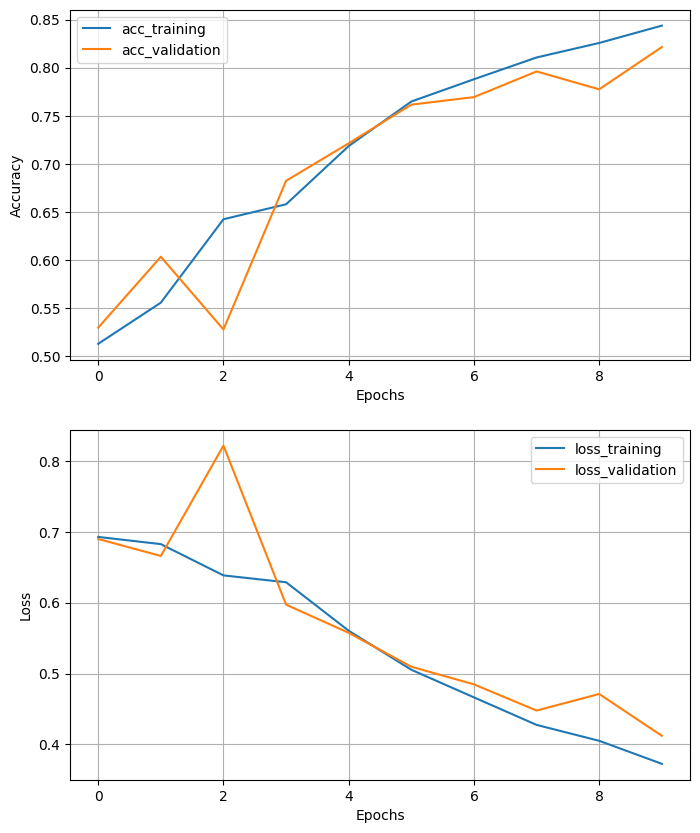

Test Loss: 0.40291035 ---------- Test Accuracy: 82.6000%


In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)
seed_setter(42)
test(model)

ANSWER: *italicised text*
**TO COMPLETE**

Discussion of the results

The RNN are simpler model compared to LSTM and GRU. <br>
Due to their simpler "architecture" the former do not captures long term dependecies and therefore their performance is expected to be lower than the latters. <br>

The code above demonstrate the previous statement. <br>
More specically the LSTM beats the RNN with an accuracy of 82.60% against 69.50%. <br>

The LSTM at time t-1 passes forward to the one at time t a more elaborated hidden state than the one of the simple RNN. The hidden state of the former model is computed by taking into consideration the output of the "Forget Gate" which essentially decides whether or not informations are to be kept. To be more precise the hidden state comes from the multiplication of "Cell state" at time t(which in turn is the result of a computation that involves also the forget gate, input gate and cell gate) with the output gate. <br>

The better performance of the LSTM comes at the cost of a larger amount of paramters. The increase in model complexity comes along with the required time for the training. <br>
Let's reason a bit about the number of paraters and time required.
- LSTM: 105,665 parameters, time required = 145.86 seconds
- simple RNN: 101,441 paramters, time required = 141.60 seconds <br>

The difference in time is not very pronounced here, because the dataset is not huge and the model underquestion are quite simple otherwise the difference would be larger.

### GRU

In this Exercise, you have to implement [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) model, similar to the previous one that, instead of exploiting the RNN layer, use an GRU layer. Print the model summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

In [ ]:
# [TO COMPLETE]
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'GRU'  #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

seed_setter(42)
model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss() #[TO COMPLETE]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─GRU: 1-2                               4,224
├─Linear: 1-3                            33
Total params: 104,257
Trainable params: 104,257
Non-trainable params: 0

In [ ]:
seed_setter(42)
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 51.84%, Loss: 0.69135439 ---------------- Val_Acc: 53.65%, Val_Loss: 0.68894678
epoch: 2 -> Accuracy: 54.84%, Loss: 0.68407214 ---------------- Val_Acc: 57.34%, Val_Loss: 0.67618674
epoch: 3 -> Accuracy: 63.71%, Loss: 0.63551950 ---------------- Val_Acc: 67.70%, Val_Loss: 0.60072118
epoch: 4 -> Accuracy: 71.18%, Loss: 0.56569684 ---------------- Val_Acc: 70.77%, Val_Loss: 0.57225472
epoch: 5 -> Accuracy: 75.66%, Loss: 0.50912732 ---------------- Val_Acc: 75.82%, Val_Loss: 0.50379938
epoch: 6 -> Accuracy: 79.03%, Loss: 0.45829737 ---------------- Val_Acc: 78.11%, Val_Loss: 0.46832448
epoch: 7 -> Accuracy: 81.87%, Loss: 0.41302988 ---------------- Val_Acc: 80.15%, Val_Loss: 0.43671092
epoch: 8 -> Accuracy: 83.94%, Loss: 0.38033429 ---------------- Val_Acc: 81.57%, Val_Loss: 0.42540175
epoch: 9 -> Accuracy: 85.08%, Loss: 0.35602242 ---------------- Val_Acc: 82.37%, Val_Loss: 0.40872440
epoch: 10 -> Accuracy: 86.72%, Loss: 0.32790300 ---------------- Val_Acc: 83.58%, 

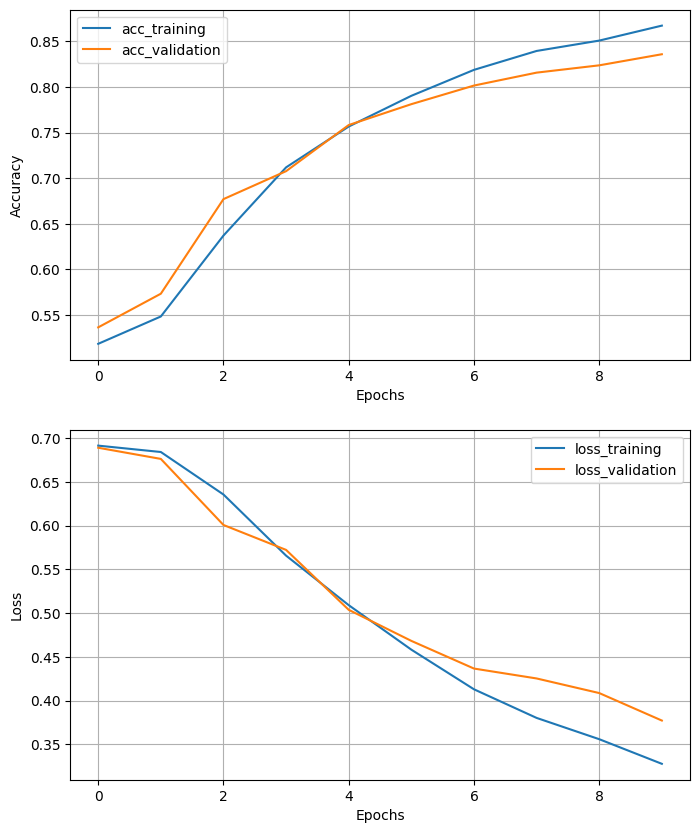

Test Loss: 0.37418631 ---------- Test Accuracy: 83.9760%


In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)
seed_setter(42)
test(model)

ANSWER: Discussion of the results

Because of their simpler architecture GRU models are expected to be faster and to consume less memory than LSTM.

However, in general the accuracy tends to be slightly better in LSTM's.

Differently from the LSTM the GRUs don't have a cell state, therefore the hidden state is the only thing that is passed forward at time t+1.

The GRU architecture is characterized by update gate and the reset gate. The former establish the amount of information that has to be passed forward whereas the latter the amount of information to forget (that's why the structure of their formula is almost identical).

Performance:
- simple RNN:  accuracy  --> 69,50%,  101,441 paramters, time required = 141.60 seconds  
- LSTM: accuracy --> 82.60%,105,665 parameters, time required = 145.86 seconds
- GRU: accuracy --> 83.97%, 104,257 parameters, time required = Training time in second: 152.84 seconds <br>

This seems to be in contrast with what said above, though it is important to notice that the dataset is quite simple and so is not enough to make differences very evident.


#BiDirectional

Let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. Try to understand what is the difference with respect to the previous model and use again the same loss you used before. This is just an extra model, so it will not be graded.


In [ ]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = True

EPOCHS = 15
lr = 3e-4

seed_setter(42)
model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = torch.nn.BCELoss()# COMPLETE
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              11,264
├─Linear: 1-3                            65
Total params: 111,329
Trainable params: 111,329
Non-trainable params: 0

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 50.58%, Loss: 0.69369656 ---------------- Val_Acc: 52.30%, Val_Loss: 0.69136578
epoch: 2 -> Accuracy: 51.91%, Loss: 0.69115275 ---------------- Val_Acc: 52.70%, Val_Loss: 0.69037777
epoch: 3 -> Accuracy: 53.01%, Loss: 0.69006914 ---------------- Val_Acc: 52.98%, Val_Loss: 0.68919319
epoch: 4 -> Accuracy: 53.68%, Loss: 0.68818820 ---------------- Val_Acc: 54.40%, Val_Loss: 0.68653643
epoch: 5 -> Accuracy: 56.77%, Loss: 0.68048656 ---------------- Val_Acc: 58.30%, Val_Loss: 0.67432940
epoch: 6 -> Accuracy: 60.14%, Loss: 0.66715109 ---------------- Val_Acc: 60.70%, Val_Loss: 0.66318101
epoch: 7 -> Accuracy: 63.01%, Loss: 0.64891368 ---------------- Val_Acc: 61.77%, Val_Loss: 0.65358019
epoch: 8 -> Accuracy: 63.61%, Loss: 0.64273876 ---------------- Val_Acc: 63.29%, Val_Loss: 0.64175719
epoch: 9 -> Accuracy: 65.62%, Loss: 0.62681496 ---------------- Val_Acc: 65.06%, Val_Loss: 0.63088697
epoch: 10 -> Accuracy: 67.72%, Loss: 0.60904294 ---------------- Val_Acc: 66.10%, 

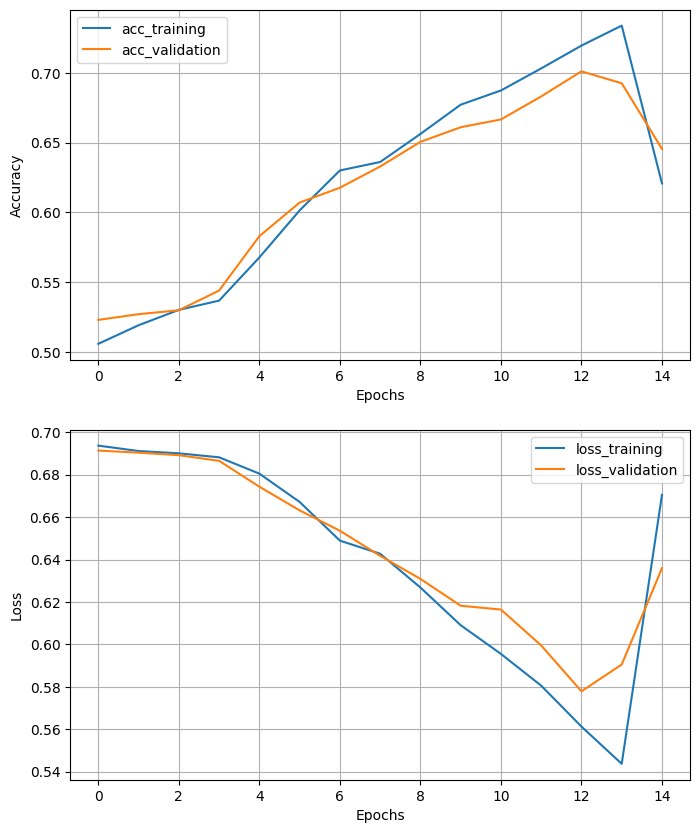

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
test(model)

Test Loss: 0.63724560 ---------- Test Accuracy: 63.9440%


# Explore relations between words

We will now quickly explore the properties of the embeddings learned by the model.

Each embedding encodes the meaning of a word inferring it from the way it is used in the dataset.

One possible way to explore the meaning encoded in the embeddings is check whether analogies that we make between concepts are reflected also in the embeddings as geometric properties.

In particular, we will compute the difference between the embeddings of two related words, thus encoding their relation in a vector.

Then, we will compute the same measure between a few couples of vectors and check if the couple which has the most similar measure corresponds to words that have the same kind of relation as the first ones.

You can try different couples of words, and you may find out that sometimes the encoding of words meanings is the one we might expect - that's why carefully choosing the training data is very important!

In [ ]:
def word_embedder(word):
  word_high_dim = sent_padding(text_pipeline(word), maxlen=seq_len).to(device)
  word_low_dim_embedded = model.embedding(word_high_dim)[-1]
  return word_low_dim_embedded

EMB_VOCAB = {}
for word in vocab.get_itos():
  EMB_VOCAB[word] =  word_embedder(word)

In [ ]:
def cosine_similarity(u, v):
    return torch.dot(u,v) / (torch.sqrt(torch.sum(u * u)) * torch.sqrt(torch.sum(v * v)))

def word_matcher(ref1, ref2, tgt3, candidates, EMB_VOCAB):
  max_thr = -np.inf
  e_ref1, e_ref2, e_tgt3 = EMB_VOCAB[ref1], EMB_VOCAB[ref2], EMB_VOCAB[tgt3]
  for w in candidates:
    e_w = EMB_VOCAB[w]
    sim = cosine_similarity(e_ref2 - e_ref1, e_w - e_tgt3)
    if sim > max_thr:
      result = w
      max_thr = sim
  return result

w1, w2, w3 = 'man', 'woman', 'king'
w4_cand = ['soldier', 'queen', 'prophet']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

w1, w2, w3 = 'germany', 'berlin', 'italy'
w4_cand = ['spain', 'rome', 'germany', 'france']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

The relation between man -> woman is like the realtion between king -> queen
The relation between germany -> berlin is like the realtion between italy -> spain


### Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise.

The structure of the transformer is defined as follows:
*   A multi-head attention layer
*   Dropout operation (`dropout_att`)
*   Layer Normalization (`layernorm_att`)
*   A feedforward Neural Network, Sequential, and Dense layer
*   Dropout operation (`dropout_fnn`)
*   Layer Normalization (`layernorm_fnn`) that has in input the summation of the attention layer output and the feedforward NN output

Your task is to experiment with different hyperparameters values and try to find a configuration of the Transformer that can beat the RNNs. In the cell below, write a short comment on the impact of each hyperparameter on model performance according to your observations.

ANSWER:
Let's start by setting the parameters to 1.
The following table summarizes the most relevant attempts that were tried out.
<table>
  <tr>
    <th></th>
    <th>d_emb</th>
    <th>n_head</th>
    <th>num_encoder_layers</th>
    <th>num_decoder_layer</th>
    <th>Accuracy</th>
  </tr>
  <tr>
    <td>bid 1 </td>
    <td>6</td>
    <td>1</td>
    <td>1</td>
    <th>1</th>
    <th>82.04%</th>
  </tr>
  <tr>
    <td>bid 2 </td>
    <td>6</td>
    <td>1</td>
    <td>3</td>
    <th>1</th>
    <th>82.41%</th>
  </tr>
    <tr>
    <td>bid 3 </td>
    <td>6</td>
    <td>1</td>
    <td>1</td>
    <th>3</th>
    <th>81.84%</th>
  </tr>
    <tr>
    <td>bid 4 </td>
    <td>12</td>
    <td>1</td>
    <td>1</td>
    <th>1</th>
    <th>84.99</th>
  </tr>
  <tr>
    <td>bid 5 </td>
    <td>12</td>
    <td>2</td>
    <td>1</td>
    <th>1</th>
    <th>84.85%</th>
  </tr>
    <tr>
    <td>bid 6 </td>
    <td>12</td>
    <td>2</td>
    <td>2</td>
    <th>2</th>
    <th>84.57%</th>
  </tr>
</table>

- 1° bid: in the first attempt a basic combination of parameter was set up.
- 2° bid: in the follwing attempt the number of encoding layers was increased in order to more enhance the "encoding capabilities" of the transformer (i.e. to get a more refined representation of the input)
- 3° bid: in the third attempt the model was set up as it was at first try and then the number of decoding layers was brought up to three. This way the effect of having more deconding layers was highlighted.
- 4° bid: The objective of the fourth attempt was to investigate the influence a longer embedding has on the performance of the transformer.
- 5° bid / 6° bid: In the last two attempts were made to further improve the perfomance achieved at the fourth one.

Due to cuda limitations it wasn't possible to use more than three layers of encodors/decoders whilst also increasing the embedding size. In fact, three percentage points were gained by simply doubling its size. Under this circumstances it was shown how important is the role of the length of the emdedding vector. By comparing the second and the third attempt it can be also pointed out that the number of encoders had a bigger effect on the model performance than the number of decoders.
Finally, the performance of the last two attempts is worse than third to the last one. This is counterintuitive, because a greater number of parameters usually leads to more complex and better performing models.




In [ ]:
seed_setter(42)
new_seq_len = 200
train_dataset_trns = CustomDataset(train_data, seq_len=new_seq_len)
val_dataset_trns = CustomDataset(val_data, seq_len=new_seq_len)
test_dataset_trns = CustomDataset(test_data, seq_len=new_seq_len)
seed_setter(42)
batch_size=256
dataloader_training_trns = DataLoader(train_dataset_trns, batch_size=batch_size, shuffle=True)
dataloader_validation_trns = DataLoader(val_dataset_trns, batch_size=batch_size)
dataloader_test_trns = DataLoader(test_dataset_trns, batch_size=batch_size)

In [ ]:
class My_Transform(nn.Module):
  def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, layer_norm_eps, device=device):
    super().__init__()
    self.device = device

    self.emb_en = Embedding(num_embeddings=len(vocab), embedding_dim=d_model)
    self.emb_de = Embedding(num_embeddings=2, embedding_dim=d_model)
    #2: because of binary classification

    self.transformer = Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                   num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward,
                                   dropout=dropout, layer_norm_eps=layer_norm_eps)

    self.linear = Linear(d_model, 1)#1: because of binary classification

  def forward(self, x, y):

    #x: (batch_size, seq_len) -> (256, 200)
    #y: (batch_size) -> (256)

    y = torch.roll(y, shifts=1, dims=0) #right shifted

    self.embedded_src = self.emb_en(x)
    #self.embedded_src: (batch_size, seq_len, d_model) -> (256, 200, 5)

    '''
    Transformer requires src_dim and trg_dim of (S, N, E)
    (S, N, E) -> (Seq_len, Batch_size, Embed_dim) -> (seq_len, batch_size, d_model)
        - self.embedded_src must be permuted
        - self.embedded_trg must be reshaped accordingly
    Transformer will produce an output of dim (T, N, E)
    (T, N, E) -> (Target_len, Batch_size, Embed_dim) -> (1, batch_size, d_model)
    '''

    self.embedded_src = self.embedded_src.permute(1, 0, 2)
    #self.embedded_src: (seq_len, batch_size, d_model) -> (200, 256, 5)
    self.embedded_trg = self.emb_de(y.unsqueeze(0).long())
    #self.embedded_trg: (seq_len:target_len, batch_size, d_model) -> (1, 256, 5)

    trns_out = self.transformer(self.embedded_src, self.embedded_trg)
    #trns_out: (target_len, batch_size, d_model) -> (1, 256, 5)

    out = self.linear(trns_out)
    #out: (1, 256, 1)

    return F.sigmoid(out.squeeze()) #(batch_size) -> (256) : Like y

In [ ]:
d_model= 12 #[TO COMPLETE]
nhead= 1 #[TO COMPLETE]
num_encoder_layers= 1 #[TO COMPLETE]
num_decoder_layers= 1 #[TO COMPLETE]
dim_feedforward=128
dropout=0.1
layer_norm_eps=1e-5

EPOCHS = 10
lr = 1e-3
seed_setter(42)
transformer = My_Transform(d_model, nhead, num_encoder_layers, num_decoder_layers,
                           dim_feedforward, dropout, layer_norm_eps).to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)

summary(transformer)

Layer (type:depth-idx)                                                 Param #
My_Transform                                                           --
├─Embedding: 1-1                                                       120,000
├─Embedding: 1-2                                                       24
├─Transformer: 1-3                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            3,884
│    │    └─LayerNorm: 3-2                                             24
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            4,532
│    │    └─LayerNorm: 3-4                                             24
├─Linear: 1-4                                                          13
Total params: 128,501
Trainable params: 128,501
Non-trainable params: 0

In [ ]:
def train_trns(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):

      optimizer.zero_grad()
      logits = model(text, label)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):

            logits = model(text, label)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [ ]:
seed_setter(42)
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_trns(transformer, optimizer, dataloader_training_trns, dataloader_validation_trns, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 53.59%, Loss: 0.68828768 ---------------- Val_Acc: 61.16%, Val_Loss: 0.65802115
epoch: 2 -> Accuracy: 67.58%, Loss: 0.60143697 ---------------- Val_Acc: 73.91%, Val_Loss: 0.53190953
epoch: 3 -> Accuracy: 75.88%, Loss: 0.50536144 ---------------- Val_Acc: 77.79%, Val_Loss: 0.47095454
epoch: 4 -> Accuracy: 79.64%, Loss: 0.44641462 ---------------- Val_Acc: 80.00%, Val_Loss: 0.43153980
epoch: 5 -> Accuracy: 82.30%, Loss: 0.40291047 ---------------- Val_Acc: 81.67%, Val_Loss: 0.40354997
epoch: 6 -> Accuracy: 83.58%, Loss: 0.37662685 ---------------- Val_Acc: 82.07%, Val_Loss: 0.39566904
epoch: 7 -> Accuracy: 85.19%, Loss: 0.34901765 ---------------- Val_Acc: 83.30%, Val_Loss: 0.37500075
epoch: 8 -> Accuracy: 86.17%, Loss: 0.32661164 ---------------- Val_Acc: 83.78%, Val_Loss: 0.36311790
epoch: 9 -> Accuracy: 86.96%, Loss: 0.31097251 ---------------- Val_Acc: 84.42%, Val_Loss: 0.36097556
epoch: 10 -> Accuracy: 87.65%, Loss: 0.29958972 ---------------- Val_Acc: 84.74%, 

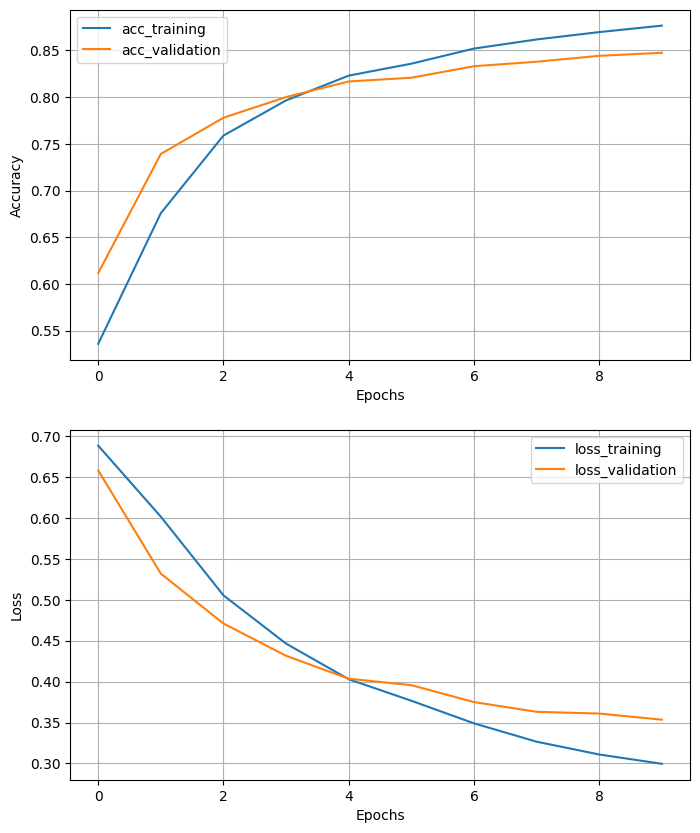

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
def test_trns(model, dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text, label)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [ ]:
gc.collect()
seed_setter(42)
test_trns(transformer, dataloader_test_trns)

Test Loss: 0.35346448 ---------- Test Accuracy: 84.9920%
